# Kuramoto model

In this example, we give an introduction to the Kuramoto model, and implement it from scratch.
Then, we use the `jaxkuramoto` package to solve the model, which is essentially the same as the from-scratch implementation.

If you are rushing into the conclusion, here is the copy-and-pastable code using `jaxkuramoto`:
    
```python
import jax; jax.config.update("jax_enable_x64", True)
from jax import random
import jax.numpy as jnp
from jaxkuramoto import odeint, Kuramoto
from jaxkuramoto.distribution import Normal
from jaxkuramoto.solver import runge_kutta

n_oscillator = 100
K = 3.0
omegas = Normal(0.0, 1.0).sample(random.PRNGKey(0), (n_oscillator,))

model = Kuramoto(omegas, K)
init_thetas = random.uniform(random.PRNGKey(1), (n_oscillator,)) * 2 * jnp.pi
sol = odeint(
    model.vector_fn,
    runge_kutta, 0, 100, 0.01, init_thetas,
    observable_fn=model.orderparameter
)
```


## Governing equations

Kuramoto model is a model of coupled oscillators {cite}`kuramoto1975`. It is a simple model of synchronization phenomena. The model is described by the following equations:

$$
\frac{\mathrm{d}\theta_{i}}{\mathrm{d}t} = \omega_{i} + \frac{K}{N}\sum_{j=1}^{N}\sin(\theta_{j}-\theta_{i})
$$

Here,
- $\theta_{i}$ is the phase of the $i$-th oscillator
- $\omega_{i}$ is the natural frequency of the $i$-th oscillator
- $K$ is the coupling strength
- $N$ is the number of oscillators.

If the coupling strength $K$ is zero, the system is decoupled and the oscillators evolve independently. If $K$ is large enough, the oscillators are expected to synchronize.
Then, we have a natural question:

> _how does the synchronization depend on the coupling strength $K$?_

In the following, we will answer this question by numerical simulations.

## Order parameter

To observe the synchronization phenomena, we will use the following **order parameters** :

$$
z = re^{i\phi} = \frac{1}{N}\sum_{j=1}^{N}\exp(i\theta_{j})
$$

The order parameter $z$ is a complex number, and it is calculated as the centroid of the oscillators moving on a circle.
$r$ is the absolute value of $z$, and it is the average distance of the oscillators from the center of the circle.
If $r$ is nearly zero, the oscillators are distributed uniformly on the circle, and they are not synchronized.
If $r$ is close to one, the oscillators are concentrated on the circle, and they are synchronized.

Let's visualize the order parameter $z$.

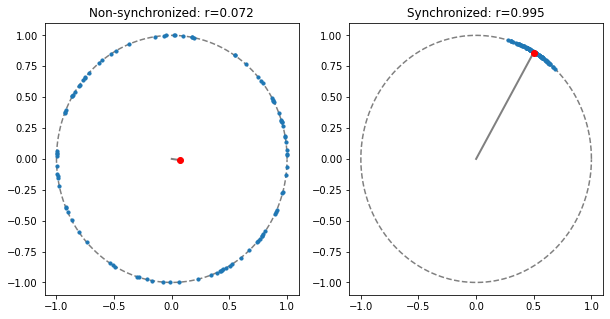

In [1]:
import jax; jax.config.update("jax_enable_x64", True)
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt

n_oscillator = 100

_thetas = jnp.arange(0, 2*jnp.pi, 0.01)
thetas_nonsync = random.uniform(random.PRNGKey(0), (n_oscillator,), maxval=2*jnp.pi)
thetas_sync = random.normal(random.PRNGKey(1), (n_oscillator,)) * 0.1 + jnp.pi / 3
rx_nonsync = jnp.mean(jnp.cos(thetas_nonsync))
ry_nonsync = jnp.mean(jnp.sin(thetas_nonsync))
r_nonsync = jnp.sqrt(rx_nonsync**2 + ry_nonsync**2)
rx_sync = jnp.mean(jnp.cos(thetas_sync))
ry_sync = jnp.mean(jnp.sin(thetas_sync))
r_sync = jnp.sqrt(rx_sync**2 + ry_sync**2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.plot(jnp.cos(_thetas), jnp.sin(_thetas), color="gray", ls="dashed", zorder=0)
plt.scatter(jnp.cos(thetas_nonsync), jnp.sin(thetas_nonsync), s=10, zorder=10)
plt.plot([0, rx_nonsync], [0, ry_nonsync], color="gray", lw=2, zorder=20)
plt.scatter([rx_nonsync], [ry_nonsync], color="red", zorder=30)
plt.title(f"Non-synchronized: r={r_nonsync:.3f}")

plt.subplot(1, 2, 2)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.plot(jnp.cos(_thetas), jnp.sin(_thetas), color="gray", ls="dashed", zorder=0)
plt.scatter(jnp.cos(thetas_sync), jnp.sin(thetas_sync), s=10, zorder=10)
plt.plot([0, rx_sync], [0, ry_sync], color="gray", lw=2, zorder=20)
plt.scatter([rx_sync], [ry_sync], color="red", zorder=30)
plt.title(f"Synchronized: r={r_sync:.3f}")
plt.show()

We see that the order parameter is a nice tool to observe the synchronization phenomena.
Now we want to know the dependence of the order parameter $r$ on the coupling strength $K$.
Let's observe this dependency by numerical simulations.

## From scratch

Let's implement the Kuramoto model from scratch.

We first implement the vector field of the Kuramoto model and the order parameter.

In [2]:
def kuramoto_vector_field(thetas, K, omegas):
    coss, sins = jnp.cos(thetas), jnp.sin(thetas)
    rx, ry = jnp.mean(coss), jnp.mean(sins)
    return omegas + K * (ry * coss - rx * sins)
def orderparameter(thetas):
    rx, ry = jnp.mean(jnp.cos(thetas)), jnp.mean(jnp.sin(thetas))
    return jnp.sqrt(rx**2 + ry**2)

```{note}
You might notice that the vector field is implemented in a way that is not same as the equation above.
This is because the original equation is not suitable for numerical simulations. For each oscillator, we need to calculate $N$ number of sum.
Hence the computational cost of the vector field is $\mathcal{O}(N^2)$, this is not acceptable for large $N$!!!

Instead, what we are doing here is to use the mean-field description of the Kuramoto model using the order parameter.
By defining the $x$-axis order parameter $r_x=\sum \cos\theta_{j}/N$ and the $y$-axis order parameter $r_y=\sum \sin\theta_{j}/N$, we can rewrite the equation as follows:

$$
\frac{\mathrm{d}\theta_{i}}{\mathrm{d}t} = \omega_{i} + K(r_{y}\cos\theta_{i}-r_{x}\sin\theta_{i})
$$

In this formulation, the computational cost is $\mathcal{O}(N)$, which is super fast compared to the original equation!!!
We also note that this formulation is easily vectorized, which is also very important for the performance.
```

Next we implement the numerical integrator for ODEs. Here we use the fourth-order Runge-Kutta method.

In [3]:
from jax import jit
from jax.lax import fori_loop

def rk4(func, state, dt):
    k1 = func(state)
    k2 = func(state + k1 * dt / 2)
    k3 = func(state + k2 * dt / 2)
    k4 = func(state + k3 * dt)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
def run(func, solver, init_state, dt, t_max, observable_fn):
    update_fn = jit(lambda state: solver(func, state, dt))
    ts = jnp.arange(0, t_max, dt)
    n_step = ts.shape[0]
    observables = jnp.zeros((n_step, ))
    observables = observables.at[0].set(observable_fn(init_state))
    def body_fn(i, val):
        state, _observables = val
        new_state = update_fn(state)
        _observables = _observables.at[i].set(observable_fn(new_state))
        return new_state, _observables
    final_state, observables = fori_loop(1, n_step, body_fn, (init_state, observables))
    return ts, observables, final_state

Now all the ingredients are ready. Let's run the simulation.
In many research papers, natural frequencies $\omega_{i}$ are chosen randomly from some distribution.
In this example, let's set the distribution to the normal distribution with mean zero and standard deviation one.
We also set the initial phases $\theta_{i}$ to be uniformly distributed on the circle.

The setting is:
- $N=100$ oscillators
- $K=1.0$ coupling strength
- $\omega_{i}\sim\mathcal{N}(0,1)$

We run the simulation from $t=0$ to $t=20$ with the time step $dt=0.01$.

In [4]:
n_oscillator = 10**2
K = 1.0
omegas = random.normal(random.PRNGKey(0), (n_oscillator,))
init_thetas = random.uniform(random.PRNGKey(1), (n_oscillator,), maxval=2*jnp.pi)

dt, t_max = 0.01, 20.0
ts, orderparams, final_thetas_0 = run(lambda thetas: kuramoto_vector_field(thetas, K, omegas), rk4, init_thetas, dt, t_max, orderparameter)

Let's visualize the time evolution of the order parameter $r$.

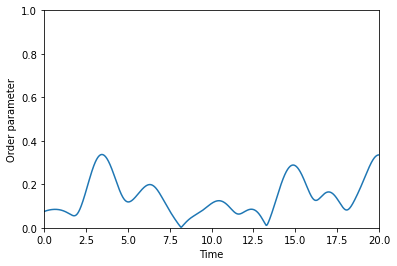

In [5]:
plt.xlim(0, t_max)
plt.ylim(0, 1.0)
plt.xlabel("Time")
plt.ylabel("Order parameter")
plt.plot(ts, orderparams)
plt.show()

It seems like the order parameter $r$ is not changing much.
The coupling strength $K$ is too small that the oscillators are not synchronized.
Next, let's increase the coupling strength $K$.

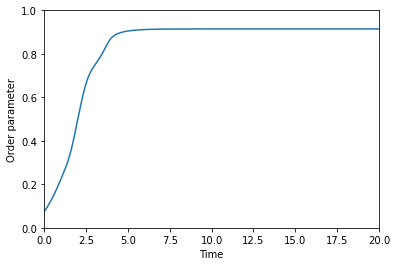

In [6]:
K = 3.0
ts, orderparams, final_thetas_1 = run(lambda thetas: kuramoto_vector_field(thetas, K, omegas), rk4, init_thetas, dt, t_max, orderparameter)

plt.xlim(0, t_max)
plt.ylim(0, 1.0)
plt.xlabel("Time")
plt.ylabel("Order parameter")
plt.plot(ts, orderparams)
plt.show()

Wow, the oscillators are synchronized! The order parameter $r$ is close to one.
Let's observe the final state of the oscillators for $K=1.0$ and $K=3.0$.

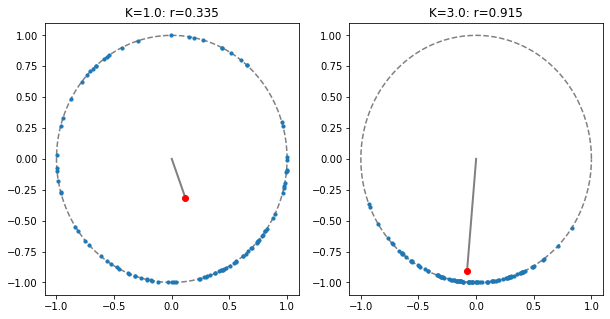

In [8]:
n_oscillator = 100

_thetas = jnp.arange(0, 2*jnp.pi, 0.01)
rx_nonsync = jnp.mean(jnp.cos(final_thetas_0))
ry_nonsync = jnp.mean(jnp.sin(final_thetas_0))
r_nonsync = jnp.sqrt(rx_nonsync**2 + ry_nonsync**2)
rx_sync = jnp.mean(jnp.cos(final_thetas_1))
ry_sync = jnp.mean(jnp.sin(final_thetas_1))
r_sync = jnp.sqrt(rx_sync**2 + ry_sync**2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.plot(jnp.cos(_thetas), jnp.sin(_thetas), color="gray", ls="dashed", zorder=0)
plt.scatter(jnp.cos(final_thetas_0), jnp.sin(final_thetas_0), s=10, zorder=10)
plt.plot([0, rx_nonsync], [0, ry_nonsync], color="gray", lw=2, zorder=20)
plt.scatter([rx_nonsync], [ry_nonsync], color="red", zorder=30)
plt.title(f"K=1.0: r={r_nonsync:.3f}")

plt.subplot(1, 2, 2)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.plot(jnp.cos(_thetas), jnp.sin(_thetas), color="gray", ls="dashed", zorder=0)
plt.scatter(jnp.cos(final_thetas_1), jnp.sin(final_thetas_1), s=10, zorder=10)
plt.plot([0, rx_sync], [0, ry_sync], color="gray", lw=2, zorder=20)
plt.scatter([rx_sync], [ry_sync], color="red", zorder=30)
plt.title(f"K=3.0: r={r_sync:.3f}")
plt.show()

We have been using the from-scrtach implementation of the Kuramoto model.
This package, `jaxkuramoto`, provides the same implementation as above with few lines of code.

## Use `jaxkuramoto` instead

We introduce `jaxkuramoto` package, which provides the Kuramoto model and the numerical integrator.
There are mainly three steps to use `jaxkuramoto`:
1. Define the distribution of the natural frequencies
2. Define the model
3. Run the simulation

### Define the distribution of the natural frequencies
In many research papers, natural frequencies $\omega_{i}$ are chosen randomly from some distribution.
`jaxkuramoto` provides several distributions, and also allows you to define your own distribution.
If you want to use the normal distribution, you can do as follows.

In [14]:
from jaxkuramoto.distribution import Normal

dist = Normal(0.0, 1.0)
omegas = dist.sample(random.PRNGKey(0), (n_oscillator,))

We are also creating other distributions. Check out [here](../distributions) for more details!!

### Define the model
Now we define the model.
We have `Kuramoto` class, which takes the natural frequencies and the coupling strength as arguments.

In [15]:
from jaxkuramoto import Kuramoto

K = 3.0
model = Kuramoto(omegas, K)

### Run the simulation

```{warning}
Currently, we are using `jaxkuramoto.odeint` for integrating ODEs.
This is because other ODE libraries are not supporting `observable_fn` option.
However, [`diffrax`](https://github.com/patrick-kidger/diffrax), numerical differentiation library for JAX, is currently implementing this functionality and will be released in the future.
We will switch to `diffrax` when it is released.
See [this issue](https://github.com/patrick-kidger/diffrax/issues/221) and [this pull request](https://github.com/patrick-kidger/diffrax/pull/220) for more details.
```

That's it! Now we can run the simulation.
We can also specify the numerical integrator, the initial time, the final time, and the time step.
`Kuramoto` class has `vector_fn` method, which returns the vector field of the Kuramoto model, and `orderparameter` method, which returns the order parameter $r$.

In [13]:
from jaxkuramoto.solver import runge_kutta
from jaxkuramoto import odeint

t0, t1, dt = 0.0, 20.0, 0.01
init_thetas = random.uniform(random.PRNGKey(1), (n_oscillator,), maxval=2*jnp.pi)
sol = odeint(model.vector_fn, runge_kutta, t0, t1, dt, init_thetas, model.orderparameter)

`odeint` returns the solution of the ODEs, which is a `Solution` class.
Let's visualize the time evolution of the order parameter $r$.

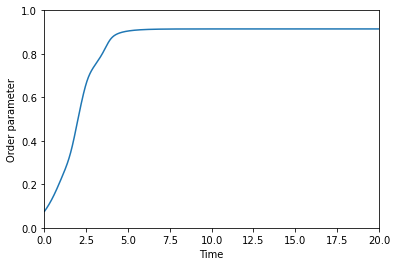

In [16]:
plt.xlim(0, t_max)
plt.ylim(0, 1.0)
plt.xlabel("Time")
plt.ylabel("Order parameter")
plt.plot(sol.ts, sol.observables)
plt.show()

`Solution` class also has a `final_state` attribute, which returns the final state of the system.

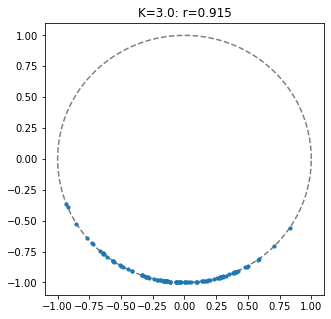

In [19]:
plt.figure(figsize=(5, 5))
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.plot(jnp.cos(_thetas), jnp.sin(_thetas), color="gray", ls="dashed", zorder=0)
plt.scatter(jnp.cos(sol.final_state), jnp.sin(sol.final_state), s=10, zorder=10)
plt.title(f"K=3.0: r={sol.observables[-1]:.3f}")
plt.show()

## Conclusion

In this example, we have learned how to use `jaxkuramoto` package to simulate the Kuramoto model.
I hope that this package will be useful for your research.

We have obseved that synchoronization can occur when the coupling strength $K$ is large.
In the next page, we calculate the exact value of $r$ with respect to $K$!!


## References

We recommend {cite}`strogatz2000` for the introduction to the Kuramoto model for those who are new to this topic.

```{bibliography}
```